In [1]:
import random
import numpy as np
import networkx as nx 
from dijkstar import Graph, find_path
from ipywidgets import IntProgress 
from IPython.display import display

In [2]:
def generate_instance_matrix(nb_vertex, min_weight, max_weight, density):
  graph = np.ones((nb_vertex, nb_vertex)) * np.inf
  for i in range(nb_vertex - 1):
    for j in range(i+1, nb_vertex):
      if random.uniform(0, 1) < density:
        weight = random.randint(min_weight, max_weight)
        graph[i, j] = weight
        graph[j, i] = weight
  for i, successors in enumerate(graph):
    index_zeros = np.where(successors == np.inf)[0]
    index_zeros = np.delete(index_zeros, np.where(index_zeros == i))
    for j in range(len(index_zeros) - (nb_vertex - 3)):
      index = random.choice(index_zeros)
      index_zeros = np.delete(index_zeros, np.where(index_zeros == index))
      weight = random.randint(min_weight, max_weight)
      graph[i, index] = weight
      graph[index, i] = weight
  return graph

def convert_graph(graph):
  graph_dijkstra = Graph()
  for i in range(len(graph)):
    for j in range(len(graph)):
      graph_dijkstra.add_edge(i, j,graph[i][j])
  return graph_dijkstra

def get_distance_between_vertices(graph, i, j):
  if (graph[i][j] != np.inf):
    return graph[i][j], [i, j]
  else:
    if i != j:
      shortest_path = find_path(graph, i,j)
      return shortest_path.total_cost, shortest_path.nodes
    else:
      return 0, None

def get_complete_graph(graph, vertices_list):
  all_paths = {}
  converted_graph = convert_graph(graph)
  complete_graph = np.zeros((len(vertices_list), len(vertices_list)))
  bar = IntProgress(min=0, max=len(vertices_list), layout={"width" : "100%"})
  display(bar)
  for vertex in vertices_list:
    successors = np.delete(vertices_list, np.where(vertices_list == vertex))
    bar.value += 1
    for successor in successors:
      distance, path = get_distance_between_vertices(converted_graph, vertex, successor)
      i = np.where(vertices_list == vertex)[0][0]
      j = np.where(vertices_list == successor)[0][0]
      complete_graph[i][j] = distance
      all_paths[(i, j)] = path
  bar.close()
  return complete_graph, all_paths

def get_random_vertices_list(size, nb_vertex):
  random_vertices_list = []
  all_vertex = np.array(range(size))
  for _ in range(nb_vertex):
    value = random.choice(all_vertex)
    random_vertices_list.append(value)
    all_vertex = np.delete(all_vertex, np.where(all_vertex == value))
  return np.array(random_vertices_list)

def generate_interval():
  interval = random.choice(range(1,4))
  shift = random.choice(range(0, 11-interval))
  return (shift*60, (shift+interval)*60)

def generate_instance(nb_vertex_matrix, min_weight, max_weight, density, vertices_list):
  graph = generate_instance_matrix(nb_vertex_matrix, min_weight, max_weight, density)
  complete_graph, all_paths = get_complete_graph(graph, vertices_list)
  return graph, complete_graph, all_paths

def get_complete_path(path, all_paths):
  complete_path = []
  for i in range(len(path) - 1):
    complete_path.extend(all_paths[(path[i], path[i+1])][:-1])
    if i == len(path) - 2:
      complete_path.append(all_paths[(path[i], path[i+1])][-1])
  return complete_path

def is_path_in_interval(path, complete_graph, interval, interval_vertex):
  weight = 0
  for i in range(np.where(np.array(path) == interval_vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

def generate_neighbours(path, complete_graph, interval, interval_vertex):
  neighbours = []
  for i in range(len(path)):
    for j in range(i + 1, len(path)):
      new_neighbour = path.copy()
      new_neighbour[i] = path[j]
      new_neighbour[j] = path[i]
      if is_path_in_interval(new_neighbour, complete_graph, interval, interval_vertex):
        neighbours.append(new_neighbour)
  return neighbours

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_random_vertex(random_vertex):
  return random.choice(random_vertex)

In [3]:
# variables
nb_vertex_matrix = 200
min_weight = 10
max_weight = 30
density = 0.7
nb_vertex_chosen = 100
population_number = 200
generation_number = 200

In [4]:
#random generation of a list of vertex among all the vertex available
vertices_list = get_random_vertices_list(nb_vertex_matrix, nb_vertex_chosen)

start_vertex = get_random_vertex(vertices_list)
start_vertex_index = np.where(vertices_list == start_vertex)[0][0]

interval_vertex = get_random_vertex(vertices_list)
interval_vertex_index = np.where(vertices_list == interval_vertex)[0][0]

interval = generate_interval()

interval = (0,100000000)

# generation of the graph, the complete graph and the list of all paths
graph, complete_graph, all_paths =\
generate_instance(
  nb_vertex_matrix = nb_vertex_matrix,
  min_weight = min_weight,
  max_weight = max_weight,
  vertices_list = vertices_list,
  density = density
)

print("vertices_list :", vertices_list)
print("start_vertex :", start_vertex)
print("start_vertex_index :", start_vertex_index)
print("interval_vertex :", interval_vertex)
print("interval_vertex_index :", interval_vertex_index)
print("interval :", interval)
print("complete_graph :")
print(complete_graph)

IntProgress(value=0, layout=Layout(width='100%'))

vertices_list : [  9  21  32  58 199  82  44  34  33  39 115 127  23  72  30  10 121 131
 114  36  47 117  74  52 132  66 190 183  46 120 151  69  59 177  19 118
 175 186 195 152 173 189 168  83 142  41 182  51  60  40  65  27  29 159
  90  24  48  75 154  63 139 196 192 194   3  97 188  22 141 181  95  43
 133 108  14 193  57  86 191 122  89  80 164  81   1  20 116 105 172  73
  18  78  67 169 123  35 166  54 112  37]
start_vertex : 44
start_vertex_index : 6
interval_vertex : 175
interval_vertex_index : 36
interval : (420, 480)
complete_graph :
[[ 0. 26. 21. ... 27. 24. 11.]
 [26.  0. 27. ... 28. 20. 23.]
 [21. 27.  0. ... 20. 22. 13.]
 ...
 [27. 28. 20. ...  0. 20. 24.]
 [24. 20. 22. ... 20.  0. 22.]
 [11. 23. 13. ... 24. 22.  0.]]


In [5]:
# generate the neighbours of a path
# neighbours = generate_neighbours(path, complete_graph, interval, 4)

In [6]:

# complete_path = get_complete_path(path, all_paths)
# print(complete_path)

In [7]:
def get_path_weight(path, complete_graph):
  weight = 0
  for i in range(len(path) - 1):
    weight += complete_graph[path[i]][path[i+1]]
  return weight

def generate_population(nb_people, complete_graph, interval, interval_vertex, start_vertex):
  population = []
  while(len(population) < nb_people):
    path = generate_random_path(len(complete_graph), start_vertex)
    if is_path_in_interval(path, complete_graph, interval, interval_vertex):
      population.append(path)
  return population

def get_best_path(population, weights):
  index = np.argmin(weights)
  return population[index], weights[index]


In [8]:
def mutate_path_insert(path, complete_graph, interval, interval_vertex):
  is_path_correct = False
  while not is_path_correct:
    start = path[0]
    path = np.delete(path, np.where(path == start))
    mutation = random.choice(path)
    path = np.delete(path, np.where(path == mutation))
    new_index = random.randint(0, len(path) - 1)
    path = np.insert(path, new_index, mutation)
    path = np.append(path, start)
    path = np.insert(path, 0, start)
    is_path_correct = is_path_in_interval(path, complete_graph, interval, interval_vertex)
  return path

def generate_children(parentA, parentB, complete_graph, interval, interval_vertex):
  start = parentA[0]
  parentA = np.delete(parentA, np.where(np.array(parentA) == start))
  parentB = np.delete(parentB, np.where(np.array(parentB) == start))
  is_path_correct = False
  while not is_path_correct:
    cut_start = random.randint(0, len(parentA) - 2)
    cut_end = random.randint(cut_start + 1, len(parentA) - 1)
    child = parentA[cut_start:cut_end]
    for i in child:
      remaining_parentB = np.delete(parentB, np.where(parentB == i))
    child = np.insert(child, len(child), remaining_parentB)
    child = np.append(child, start)
    child = np.insert(child, 0, start)
    is_path_correct = is_path_in_interval(child, complete_graph, interval, interval_vertex)
  return child

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_best_population(population):
  return np.argpartition(population, -int(len(population)/4))[:int(len(population)/4)]

def generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index):
  children = []
  for _ in range(population_number):
    P1 = random.choice(best_people)
    # child = generate_children(P1, P2, complete_graph, interval, interval_vertex_index)
    child = mutate_path_insert(P1, complete_graph, interval, interval_vertex_index)
    children.append(child)
  return children

def evalute_population_weight(population, complete_graph):
  weights = []
  for path in population:
    weight = get_path_weight(path, complete_graph)
    weights.append(weight)
  return weights

def evolve(population, complete_graph, interval, interval_vertex_index):
  best_weight = np.inf
  best_path = []
  all_best_weights = np.array([])
  bar = IntProgress(min=0, max=generation_number, layout={"width" : "100%"})
  display(bar)
  for i in range(generation_number):
    bar.value += 1
    weights = evalute_population_weight(population, complete_graph)
    best_pop_path, best_pop_weight = get_best_path(population, weights)
    all_best_weights = np.append(all_best_weights,best_pop_weight)
    if(best_pop_weight < best_weight):
      best_weight = best_pop_weight
      best_path = best_pop_path
    best_people = np.array(population)[get_best_population(weights)]
    population = generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index)
  bar.close()
  return best_path, best_weight, all_best_weights

In [12]:
population = generate_population(population_number, complete_graph, interval, interval_vertex_index, start_vertex_index)
best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)
print(best_path, best_weight)
# print(complete_graph)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

[ 6 56 66  9 46 34 71 74 18 63 76 41 53 64 69 81 87 55 24 49 27 16 37 84
 57 48 51 93 88 32 13 60 31 22 94 39 96 68 77 75 29  8 25 91 52 95 14 72
 78 92 85 58 70 36 80 20 62 42 90 67 97 43 89 19 79  4 28 38 65  3 98 12
 47 59 40 45 82 33 30 73 35  0 54  2  7 44  5  1 15 21 99 10 50 17 26 86
 11 83 23 61  6] 1500.0


Text(0, 0.5, 'weight')

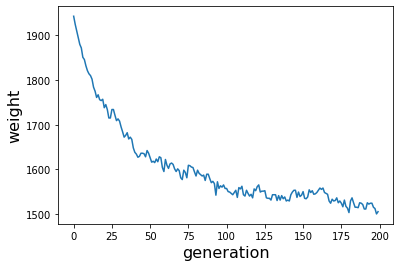

In [13]:
import matplotlib.pyplot as plt

res = plt.plot(range(len(all_best_weights)), all_best_weights)
plt.xlabel("generation", fontsize=16)
plt.ylabel("weight", fontsize=16)